In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
root_dir = '/home/dancette/doc/remi/explain'
data_dir = '/home/dancette/doc/remi/explain/data'
imgnet_dir = '/local/common-data/imagenet_2012/images'
if sys.path[0] != root_dir:
    sys.path[0] = root_dir
for x in sys.path:
    print(x)

/home/dancette/doc/remi/explain
/home/dancette/miniconda3/envs/murel/lib/python37.zip
/home/dancette/miniconda3/envs/murel/lib/python3.7
/home/dancette/miniconda3/envs/murel/lib/python3.7/lib-dynload

/home/dancette/.local/lib/python3.7/site-packages
/home/dancette/miniconda3/envs/murel/lib/python3.7/site-packages
/home/dancette/doc/faster-rcnn.pytorch/lib
/home/dancette/doc/pythia
/home/dancette/miniconda3/envs/murel/lib/python3.7/site-packages/nltk-3.4.1-py3.7.egg
/home/dancette/doc/vqa-maskrcnn-benchmark
/home/dancette/doc/block.bootstrap.pytorch
/home/dancette/doc/bootstrap.pytorch
/home/dancette/miniconda3/envs/murel/lib/python3.7/site-packages/IPython/extensions
/home/dancette/.ipython


In [55]:
import os
import json
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import quickshift
from skimage.segmentation import mark_boundaries
from explain.utils import set_seed
from explain.utils import get_input_tensors
from explain.utils import get_pil_transform
from explain.utils import get_preprocess_transform
from explain.utils import get_image
from explain.utils import batch_predict
from explain.utils import exponential_kernel
from explain.utils import mask_distance
from explain.utils import display_masked_img
from explain.utils import sample_around_img

In [14]:
set_seed(1337)

In [20]:
model = torchvision.models.inception_v3(pretrained=True)
model.cuda()
model.eval()

print('Model: pretrained InceptionV3')

Model: pretrained InceptionV3


In [18]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath(f'{data_dir}/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

In [21]:
imagenet_data = torchvision.datasets.ImageFolder(imgnet_dir)

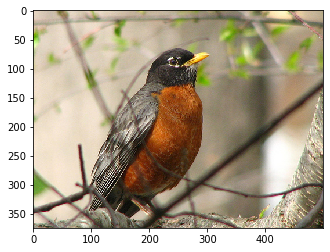

In [25]:
img_id = 20000
pil_img = imagenet_data[img_id][0]
plt.imshow(pil_img)

In [28]:
img_t = get_input_tensors(pil_img)
img_t = img_t.cuda()
logits = model(img_t)
logits = logits.cpu()
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
top5 = tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

pill_transf = get_pil_transform()
item_tf = get_preprocess_transform()
img = np.array(pill_transf(pil_img))

class_id = top5[0][1]

for score, cid, cname in top5:
    print(score, cid, cname)
    
print('current class', top5[0][2])

0.9999994 15 robin
2.1932277e-07 912 worm_fence
2.0852905e-08 10 brambling
1.457679e-08 20 water_ouzel
1.0454047e-08 951 lemon


In [32]:
scoring_fn = lambda x: batch_predict(x, model, item_tf)
segmentation_fn = lambda x: quickshift(x,
    kernel_size=4,
    max_dist=200,
    ratio=0.2)
distance_fn = mask_distance
kernel_fn = lambda x : exponential_kernel(x, width=.25)

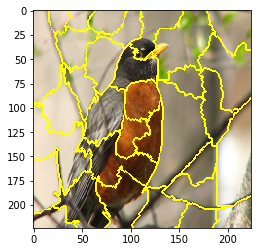

In [39]:
segments = segmentation_fn(img)
plt.imshow(mark_boundaries(img, segments))

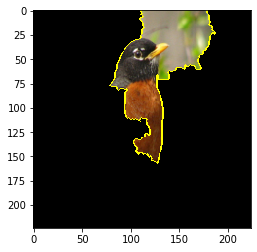

In [37]:
from explain.lime import explain_img as explain_img_lime

masked_segments = explain_img_lime(
    img,
    scoring_fn,
    segmentation_fn,
    distance_fn,
    kernel_fn,
    class_id,
    n_best_segments=5)

display_masked_img(img, masked_segments)

In [46]:
masks, targets, features = sample_around_img(
    img,
    segments,
    scoring_fn,
    n_samples=1000,
    bsize=10,
    segment_color='black')

class robin (0.9999994039535522)
class worm_fence (2.1932277149971924e-07)
class brambling (2.0852905180390735e-08)
class water_ouzel (1.4576790441367393e-08)
class lemon (1.045404740551703e-08)


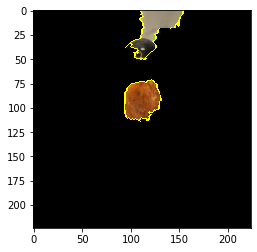

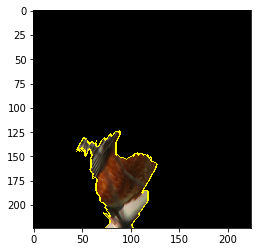

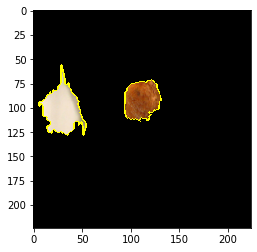

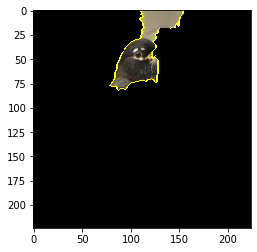

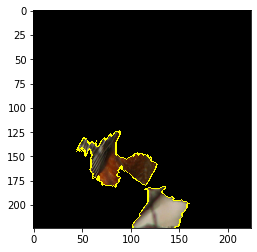

In [54]:
from explain.lime import score_segments as score_segments_lime
from explain.lime import make_masked_segments as make_masked_segments_lime

for score, cid, cname in top5:
    print(f'class {cname} ({score})')
    scores = score_segments_lime(
        masks,
        targets,
        features,
        mask_distance,
        kernel_fn,
        cid)

    masked_segments = make_masked_segments_lime(
        scores,
        segments,
        n_best_segments=2)

    display_masked_img(img, masked_segments)

n_iter:1  upper_bound_second_best:1.0 lower_bound_best:0.714
n_iter:2  upper_bound_second_best:1.0 lower_bound_best:0.778
n_iter:3  upper_bound_second_best:1.0 lower_bound_best:0.859
15 0.9280719280719281 0.9280719280719281
n_iter:1  upper_bound_second_best:1.0 lower_bound_best:0.976


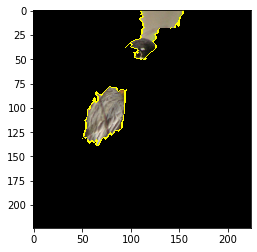

In [53]:
from explain.anchor import explain_img as explain_img_anchor

masked_segments = explain_img_anchor(
    img,
    scoring_fn,
    segmentation_fn,
    class_id,
    tau=0.95,
    eps=0.15,
    delta=1,
    bsize=100,
    n_samples=500,
    B=1)

display_masked_img(img, masked_segments)